> This notebook is part of the [Graph Neural Network Course](https://github.com/mlabonne/Graph-Neural-Network-Course) by [@maximelabonne](https://twitter.com/maximelabonne).

In [1]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 71.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Dataset

- It contains 19,717 scientific publications about diabetes from PubMed's database

- Node features are TF-IDF weighted word vectors with 500 dimensions, which is an efficient way of summarizing documents without transformers

- The task is a multi-class classification with three categories: diabetes mellitus experimental, diabetes mellitus type 1, and diabetes mellitus type 2

In [2]:
import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


- PubMed has an insanely low number of training nodes compared to the whole graph. There are only 60 samples to learn how to classify the 1000 test nodes.

# Mini-batching

Subgraph 0: Data(x=[404, 500], edge_index=[2, 453], y=[404], train_mask=[404], val_mask=[404], test_mask=[404], n_id=[404], e_id=[453], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[249, 500], edge_index=[2, 298], y=[249], train_mask=[249], val_mask=[249], test_mask=[249], n_id=[249], e_id=[298], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[282, 500], edge_index=[2, 320], y=[282], train_mask=[282], val_mask=[282], test_mask=[282], n_id=[282], e_id=[320], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[194, 500], edge_index=[2, 224], y=[194], train_mask=[194], val_mask=[194], test_mask=[194], n_id=[194], e_id=[224], input_id=[12], batch_size=12)


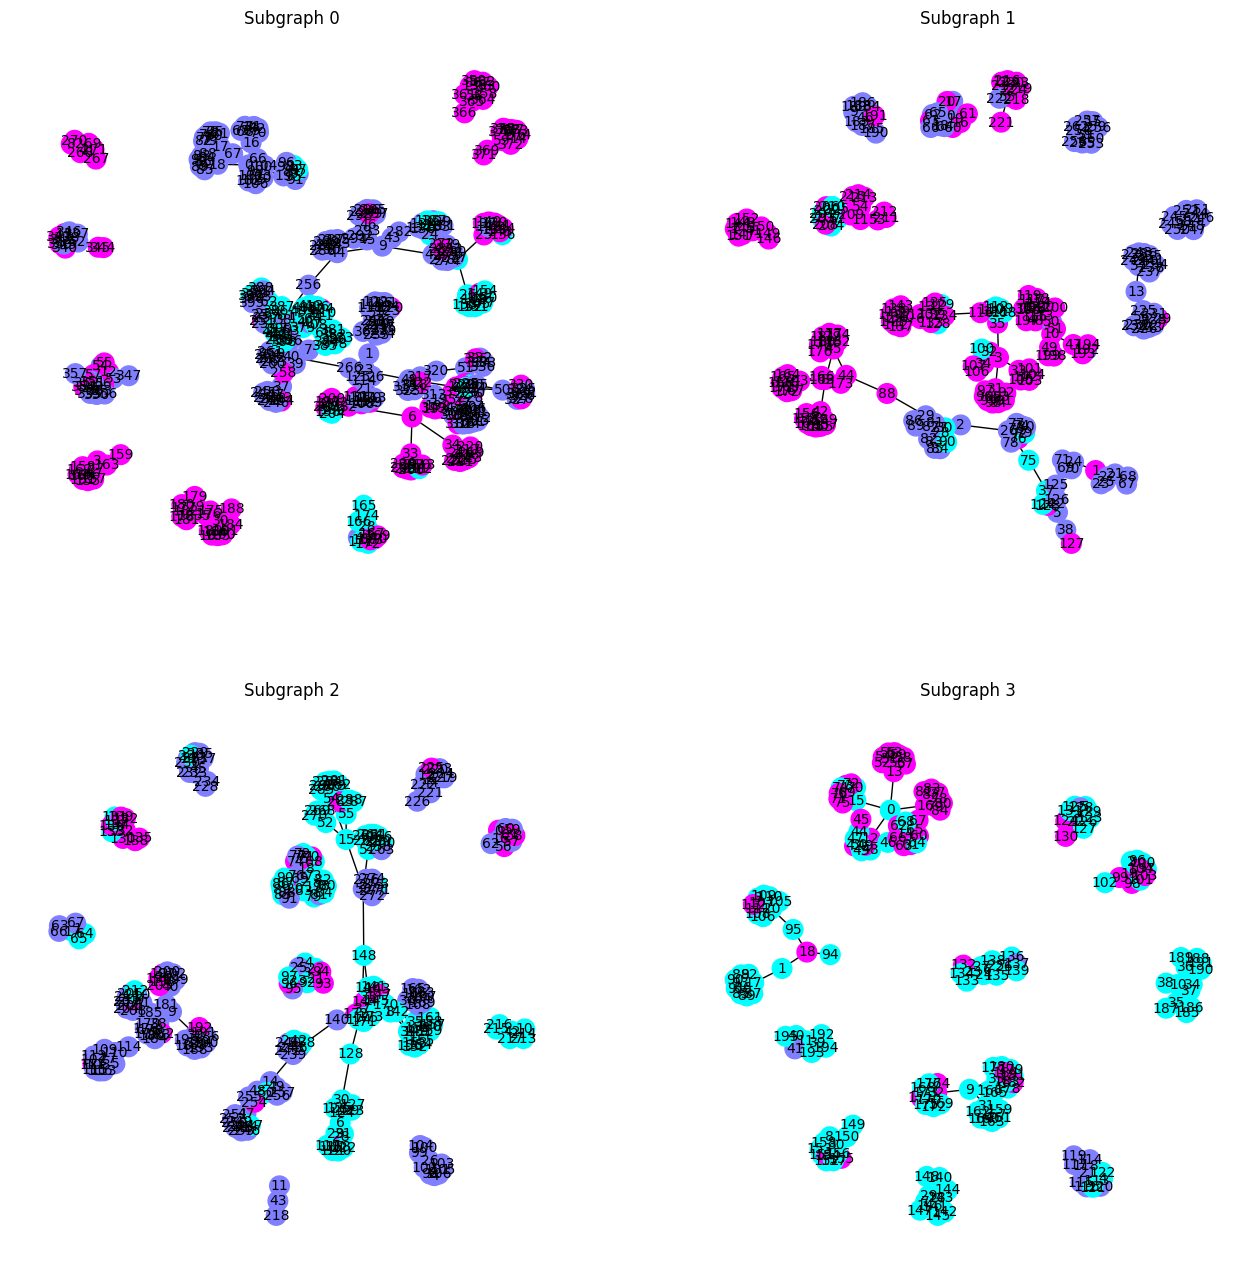

In [11]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, ['221', '222', '223', '224'])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(int(pos))
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

Note that the nubmber of batches depends on `batch_size`, and the number of target nodes
`num_batches = ceil(num_target_nodes / batch_size)`

In our case: `ceil(60 / 16) = 4`

# Plot node degrees

The number of neighbors is an important parameter since pruning our graph removes a lot of information. How much, exactly? Well, quite a lot. We can visualize this effect by looking at the node degrees (number of neighbors).

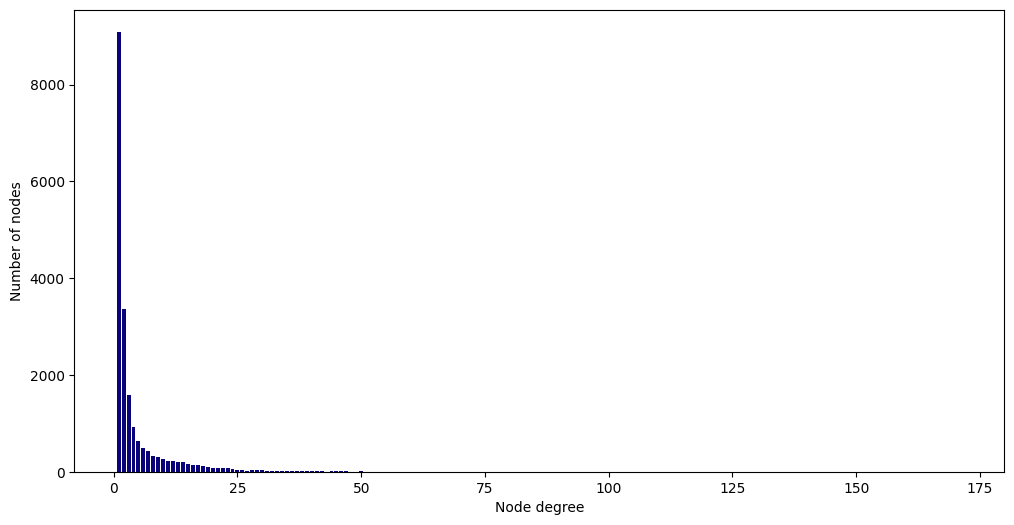

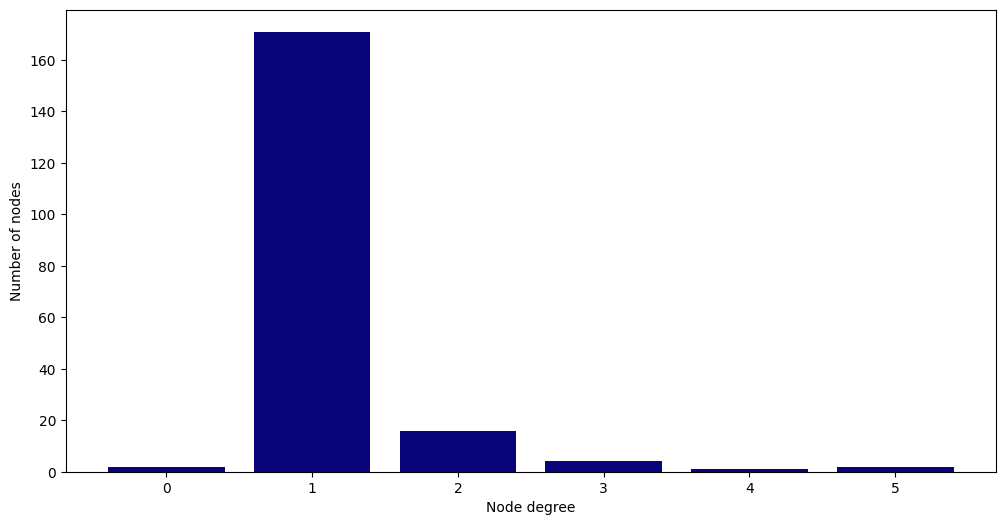

In [12]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

The first plot shows the original distribution of node degrees, and the second one shows the distribution we obtain after neighbor sampling. In this example, we chose to only consider five neighbors, which is much lower than the original maximal value.

# Implement GraphSage vs. GAT vs. GCN

To see the benefits of GraphSAGE, let's compare it with a GCN and a GAT without any sampling.

In [13]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        _, out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GraphSAGE

In [14]:
%%time
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.323 | Train Acc:  23.09% | Val Loss: 1.11 | Val Acc: 40.22%
Epoch  10 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss: 0.66 | Val Acc: 76.08%
Epoch  20 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.48 | Val Acc: 78.79%
Epoch  30 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 78.60%
Epoch  40 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 79.52%
Epoch  50 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.52 | Val Acc: 87.38%
Epoch  60 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.54 | Val Acc: 79.51%
Epoch  70 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 72.50%
Epoch  80 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 76.25%
Epoch  90 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 76.01%
Epoch 100 | Train Loss: 0.002 | Train Acc: 100.00

# Train GCN

In [15]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 64)
  (gcn2): GCNConv(64, 3)
)
Epoch   0 | Train Loss: 1.097 | Train Acc:  38.33% | Val Loss: 1.10 | Val Acc: 39.40%
Epoch  10 | Train Loss: 0.739 | Train Acc:  91.67% | Val Loss: 0.89 | Val Acc: 70.00%
Epoch  20 | Train Loss: 0.361 | Train Acc:  95.00% | Val Loss: 0.67 | Val Acc: 75.80%
Epoch  30 | Train Loss: 0.213 | Train Acc:  98.33% | Val Loss: 0.62 | Val Acc: 76.60%
Epoch  40 | Train Loss: 0.125 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.60%
Epoch  50 | Train Loss: 0.094 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 75.20%
Epoch  60 | Train Loss: 0.097 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 77.60%
Epoch  70 | Train Loss: 0.082 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 75.40%
Epoch  80 | Train Loss: 0.097 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 77.40%
Epoch  90 | Train Loss: 0.070 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 76.00%
Epoch 100 | Train Loss: 0.079 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 76

# Train GAT

In [16]:
%%time
# Create GAT
gat = GAT(dataset.num_features, 64, dataset.num_classes)
print(gat)

# Train
gat.fit(data, 200)

# Test
print(f'\nGAT test accuracy: {test(gat, data)*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(500, 64, heads=8)
  (gat2): GATv2Conv(512, 3, heads=8)
)
Epoch   0 | Train Loss: 3.138 | Train Acc:  25.00% | Val Loss: 3.14 | Val Acc: 23.80%
Epoch  10 | Train Loss: 0.712 | Train Acc:  91.67% | Val Loss: 0.87 | Val Acc: 72.40%
Epoch  20 | Train Loss: 0.347 | Train Acc:  93.33% | Val Loss: 0.65 | Val Acc: 74.40%
Epoch  30 | Train Loss: 0.191 | Train Acc:  93.33% | Val Loss: 0.59 | Val Acc: 77.20%
Epoch  40 | Train Loss: 0.120 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 77.20%
Epoch  50 | Train Loss: 0.077 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 77.80%
Epoch  60 | Train Loss: 0.075 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 79.40%
Epoch  70 | Train Loss: 0.072 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.074 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 77.40%
Epoch  90 | Train Loss: 0.065 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 78.60%
Epoch 100 | Train Loss: 0.051 | Train Acc: 100.00% | Val L